Le dataset que nous utilisons dans cette analyse concerne un ensemble de données de la NASA obtenu à partir d’une série d’essais aérodynamiques et acoustiques de sections de pales bidimensionnelles et tridimensionnelles menées dans une soufflerie anéchoïque.
<br>
<br>
**Statistiques de base :**
* Nombre de lignes : 1503
* Nombre de colonnes : 6
* Valeurs manquantes : 0
<br>
<br>

**Objectif de l'analyse :**
<br>
Notre objectif principal est de développer un modèle de prédiction pour le niveau de pression acoustique mis à l'échelle en décibels. Pour cela nous allons utiliser une technique de régression.
<br>
<br>

**Sources utilisées :**
<br>

# **Imports <br> Initialisation des variables**

In [1]:
# pip install scikit-learn, xgboost, catboost, lightgbm, matplotlib, numpy, pandas, seaborn, MiniSom
from sklearn.ensemble import (BaggingRegressor,
                              ExtraTreesRegressor,
                              RandomForestRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             mean_absolute_error as MAE,
                             mean_squared_error as MSE,
                             precision_score,
                             recall_score,
                             r2_score)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from skopt import BayesSearchCV

from xgboost import XGBRegressor
# !pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import numpy as np
# print(np.__version__)

import pandas as pd
import seaborn as sns

# !pip install MiniSom
from minisom import MiniSom

data = pd.read_csv(r'C:\Users\godai\Documents\BUT\3e_annee\semestre_5\Données massives\AirfoilSelfNoise.csv')


# **Renommage des colonnes**

In [2]:
data = data.rename(columns={'f': 'fq_hertz',
                            'alpha': 'angle_attaque',
                            'c': 'longueur_corde',
                            'U_infinity': 'vitesse_flux_libre',
                            'delta': 'epaisseur_dep_aspiration',
                            'SSPL': 'pression_accoustique'})
display(data.head(2))

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201


# **Apperçu du dataset**

In [36]:
# apperçu des données*
print("\tDIMENSIONS DU DATA (lignes, colonnes) :", data.shape)
print("\n\n\tPREMIERES LIGNES")
display(data.head(3))
print("\n\n\tINFORMATIONS SUR LE DATA")
print(data.info(), "\n\n")

	DIMENSIONS DU DATA (lignes, colonnes) : (1503, 6)


	PREMIERES LIGNES


,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951




	INFORMATIONS SUR LE DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fq_hertz                  1503 non-null   int64  
 1   angle_attaque             1503 non-null   float64
 2   longueur_corde            1503 non-null   float64
 3   vitesse_flux_libre        1503 non-null   float64
 4   epaisseur_dep_aspiration  1503 non-null   float64
 5   pression_accoustique      1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None 




# **Nettoyage et statistiques récapitulatives du dataset**

In [4]:
# affichage des données nulles
display(data.isnull().sum())

data = data.dropna() # supprimer les lignes qui contiennent des valeurs manquantes
data = data.drop_duplicates() # supprimer les doublons

fq_hertz                    0
angle_attaque               0
longueur_corde              0
vitesse_flux_libre          0
epaisseur_dep_aspiration    0
pression_accoustique        0
dtype: int64

## Remarque
Pas de valeurs manquantes

In [5]:
display(data.describe())

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Remarques
On remarque des valeurs aberrantes dans la première et la deuxième colonnes car le maximum est très éloigné du 3e quartile.

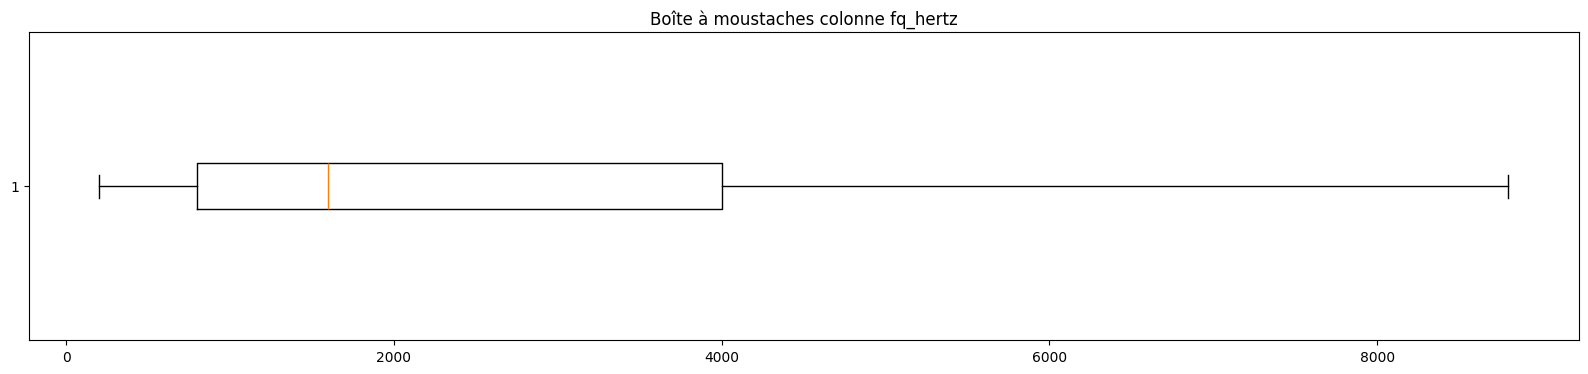

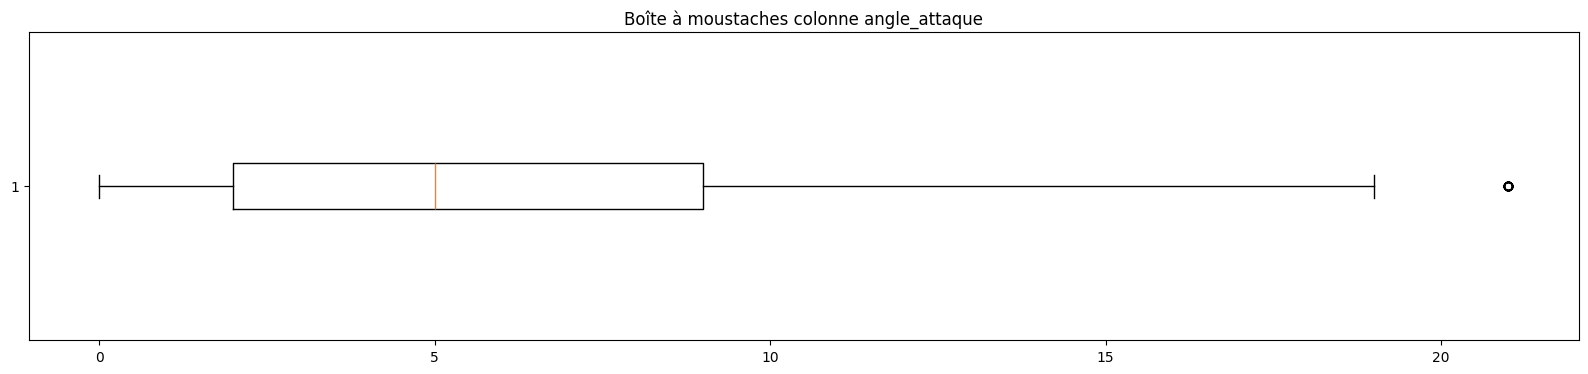

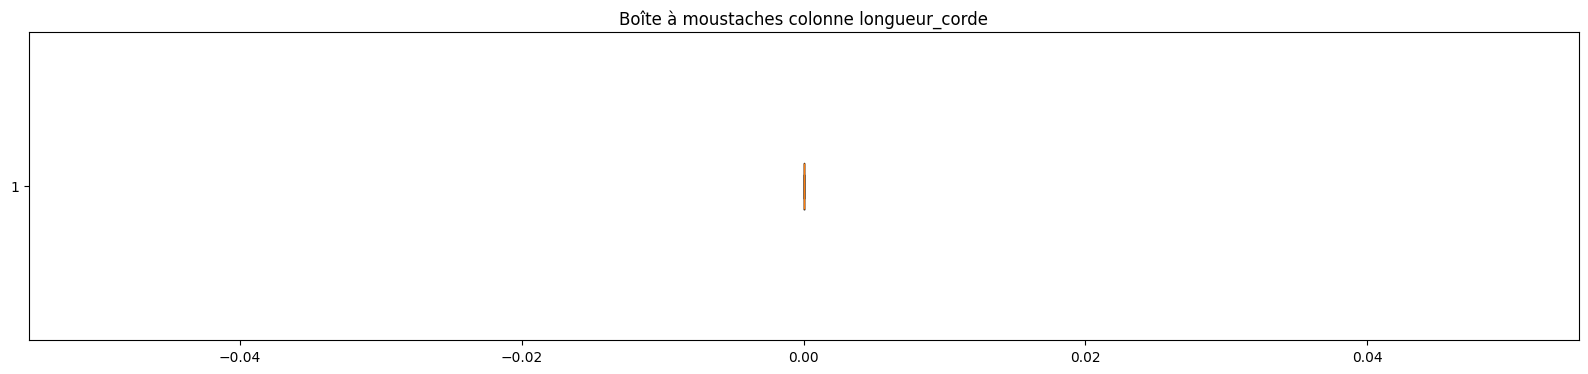

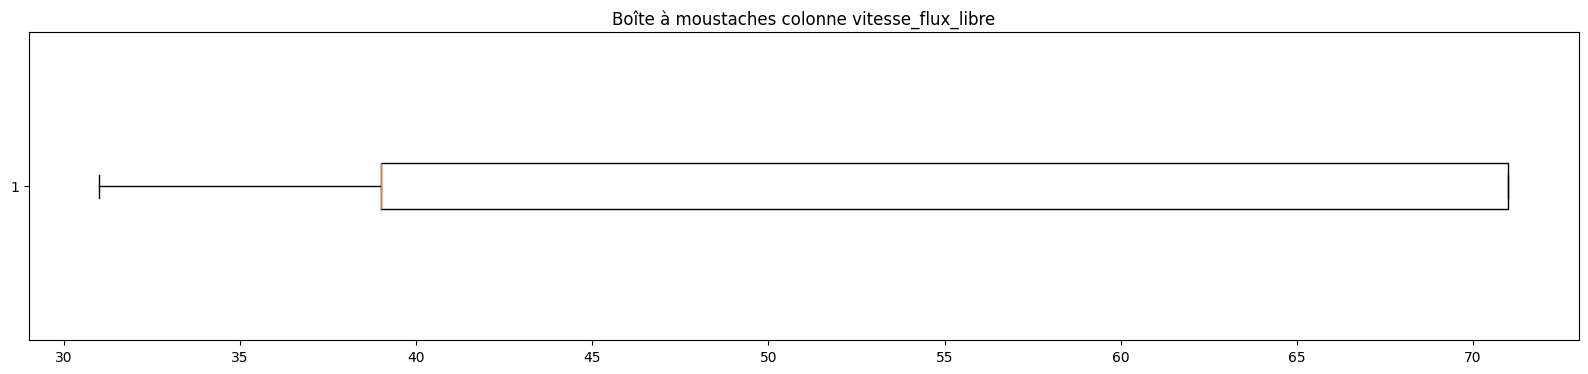

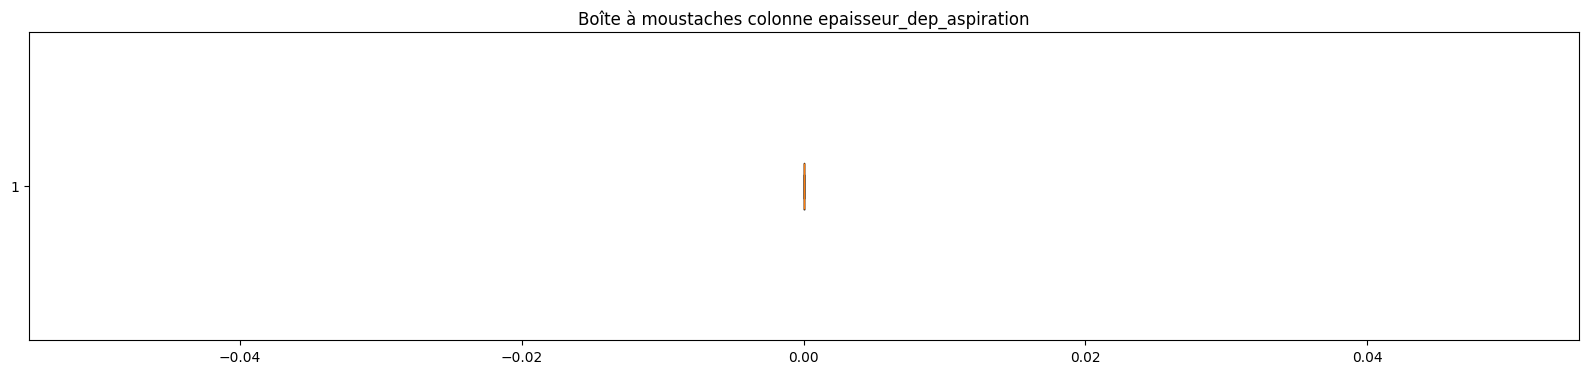

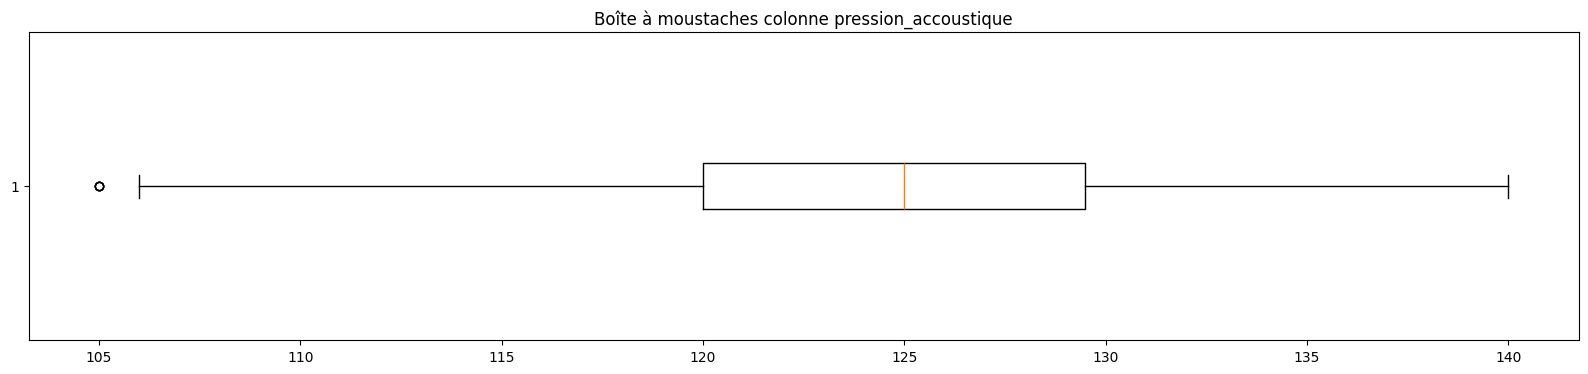

In [6]:
def remplacer_valeurs_aberrantes(data, column):
  valeurs = data[column].astype(float)

  # Calcul des quartiles
  q1 = valeurs.quantile(0.25)
  q3 = valeurs.quantile(0.75)

  # Calcul de la plage interquartiles
  iqr = q3 - q1

  # Calcul des limites des moustaches
  moustache_inferieure = q1 - 1.5 * iqr
  moustache_superieure = q3 + 1.5 * iqr

  # Remplacement des valeurs aberrantes par des valeurs entre le premier et le troisième quartile
  data.loc[data[column] < moustache_inferieure, column] = moustache_inferieure
  data.loc[data[column] > moustache_superieure, column] = moustache_superieure


def affichage_box_plot(column):
  valeurs = data[column].astype(int).tolist()
  plt.figure(figsize=(20, 4))
  plt.boxplot(valeurs, vert=False)
  plt.title(f'Boîte à moustaches colonne {column}')
  plt.show()

for column in data.columns:
    remplacer_valeurs_aberrantes(data, column)
    affichage_box_plot(column)

# **=========================================================================================Exploratory_Data_Analysis_(EDA)=========================================================================================**

In [ ]:
data.hist(bins=20, figsize=(12, 8))
plt.show()

# **Matrice de corrélation**

In [ ]:
# variables
matrice = data.corr()

# graph
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

## Remarques
* -1 < valeurs matrice < 1
    - valeur proche de 1 --> corrélation forte
    - valeur proche de 0 --> corrélation faible
    - valeur proche de -1 --> corrélation négative
* valeurs > 0 --> corrélation positive : les deux variables augmentent ou diminuent ensemble
* valeurs < 0 --> corrélation négative : les deux variables augmentent ou diminuent dans des directions opposées
<br>
<br>

On remarque principalement que :
* il y a une corrélation positive entre l'angle d'attaque et l'épaisseur du déplacement coté aspiration
* il y a une corrélation négative entre l'angle d'attaque et la longueur de la corde
* il y a une corrélation négative entre la pression accoustique et la fréquence